In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.all import *

import os
import numpy as np
import pandas as pd
bs = 64

In [2]:
# load data
path = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\train"
matches = []
for root, dirnames, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith(('.png')) and "cp" not in filename:
#             print (filename)
            matches.append(os.path.join(root, filename))
print (len(matches))

4117


In [3]:
df = pd.DataFrame(matches, columns = ["img_path"])

df.loc[:, "fname"] = df["img_path"].str.split("\\", expand = True)[8]
df.loc[:, "ts"] = df.fname.apply(lambda x: int(x.split("D")[0][1:]))

# create a list of our conditions
conditions = [
    (df['fname'].str.contains("un")), 
    (df['ts'] <= 14),
    (df['ts'] > 14) & (df['ts'] <= 32),
#     (df['ts'] > 9) & (df['ts'] <= 15),
    (df['ts'] > 32)
    ]

# create a list of the values we want to assign for each condition
# values = ["un", 'ring', 'troph', 'shiz']
values = np.arange(4)
# create a new column and use np.select to assign values to it using our lists as arguments
df['label'] = np.select(conditions, values)

In [4]:
df.groupby("label").count()

,img_path,fname,ts
label,,,
0,1169,1169,1169
1,879,879,879
2,1170,1170,1170
3,899,899,899


In [68]:
df.ts.unique()

array([ 0, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28,  2, 30, 32, 34, 36, 38,
       40, 42, 44, 46, 48,  4,  6,  8], dtype=int64)

In [5]:
dls = ImageDataLoaders.from_df(df[["fname", "label"]], path = path, 
                                valid_pct=0.2, seed=42,
#                                ds_tfms = get_transforms(),
                               item_tfms=Resize(460), batch_tfms= [*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)],
                               size=224, bs=bs, 
#                                item_tfms=Resize(224)
                               )

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


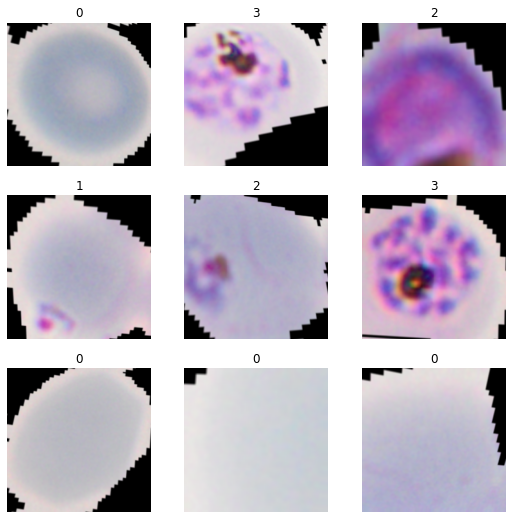

In [6]:
dls.show_batch()

In [7]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.129590,0.505263,0.184690,00:36


epoch,train_loss,valid_loss,error_rate,time
0,0.566189,0.317711,0.114216,00:24


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

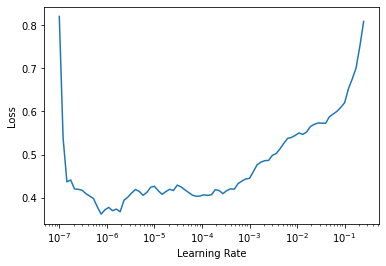

In [8]:
learn.lr_find()

In [9]:
learn.fine_tune(3, 2e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.397469,0.312098,0.113001,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.395720,0.323079,0.116646,00:24
1,0.392428,0.308867,0.110571,00:24
2,0.395304,0.314060,0.109356,00:24


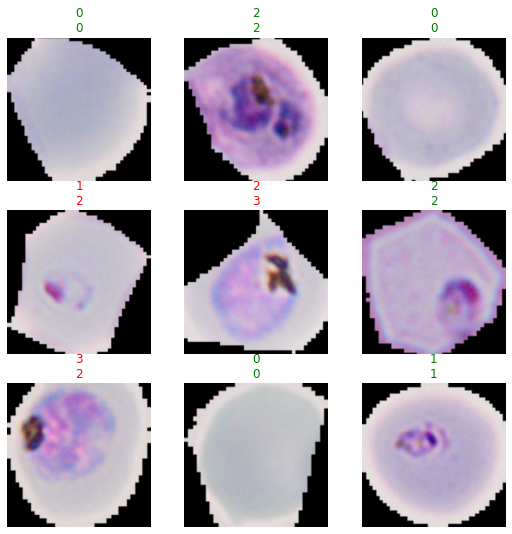

In [10]:
learn.show_results()

In [11]:
interp = Interpretation.from_learner(learn)

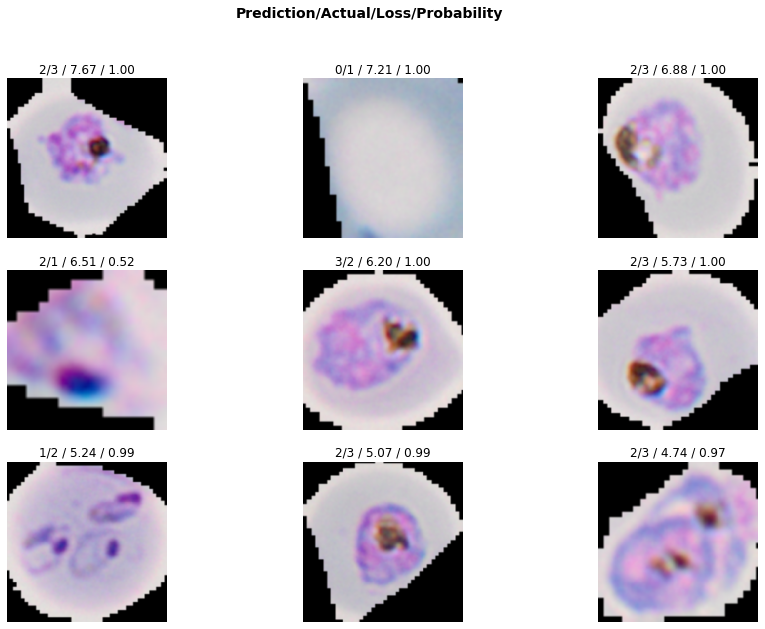

In [12]:
interp.plot_top_losses(9, figsize=(15,10))

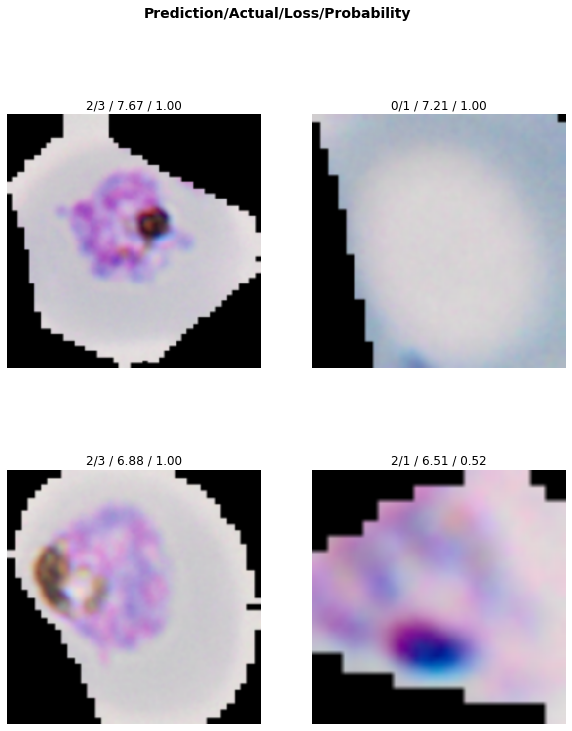

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(4, figsize=(10,12))

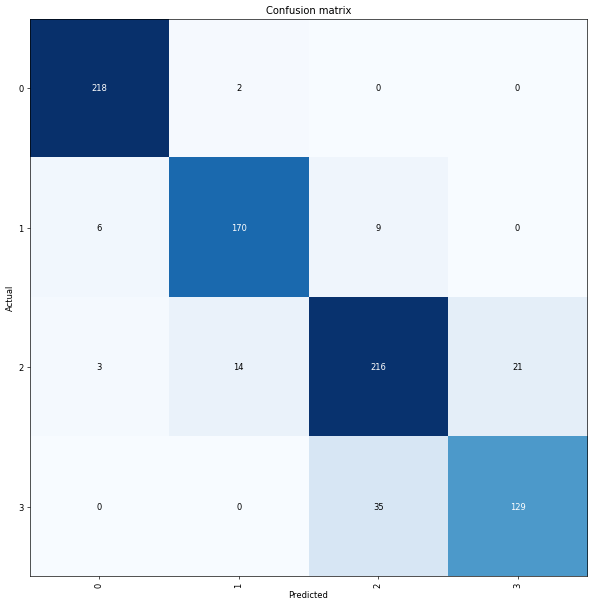

In [15]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=9.12010818865383e-07)

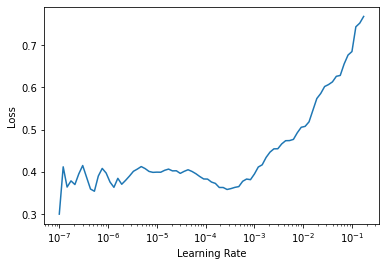

In [16]:
learn.unfreeze()
learn.lr_find()

In [17]:
learn.fit_one_cycle(2, slice(1e-7,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.386049,0.291953,0.106926,00:24
1,0.398154,0.299347,0.109356,00:24


### Testing model

In [ ]:
path = r"C:\Users\AChub_Lab\Desktop\my_project\cell_images\cell_images\Parasitized"
images = get_image_files(path)
my_learn = load_learner(r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\train\test.pkl")
dl = my_learn.dls.test_dl(images)
a, b, c = my_learn.get_preds(dl = dl, with_decoded=True)

In [ ]:
(c!=0).sum()/len(images)

In [93]:
test_path = r"C:\Users\AChub_Lab\Desktop\my_project\Falciparum-20210224T184021Z-001\Falciparum\crops"
matches = []
for root, dirnames, filenames in os.walk(test_path):
    for filename in filenames:
        if filename.endswith(('.png')) and "G" not in filename:
#             print (filename)
            matches.append(os.path.join(root, filename))
print (len(matches))

1231


In [129]:
df_test = pd.DataFrame(matches, columns = ["img_path"])
df_test.loc[:, "stage"] = df_test["img_path"].str.split("\\", expand = True)[8]
df_test.loc[:, "fname"] = df_test["img_path"].str.split("\\", expand = True)[9]
# df_test.loc[:, "ts"] = df_test.folder.apply(lambda x: int(x.split("D")[0][1:]))

In [130]:
# create a list of our conditions
conditions = [
#     (df['folder'].str.contains("un")), 
    (df_test['stage'] == "R"),
    (df_test['stage'] == "T"),
#     (df['ts'] > 9) & (df['ts'] <= 15),
    (df_test['stage'] == "S")
    ]

# create a list of the values we want to assign for each condition
# values = ["un", 'ring', 'troph', 'shiz']
values = np.arange(1, 4)
# create a new column and use np.select to assign values to it using our lists as arguments
df_test['label'] = np.select(conditions, values)

In [131]:
df_test.head()

,img_path,stage,fname,label
0,C:\Users\AChub_Lab\Desktop\my_project\Falciparum-20210224T184021Z-001\Falciparum\crops\R\1305121398-0001-R_S_0.png,R,1305121398-0001-R_S_0.png,1
1,C:\Users\AChub_Lab\Desktop\my_project\Falciparum-20210224T184021Z-001\Falciparum\crops\R\1305121398-0001-R_S_2.png,R,1305121398-0001-R_S_2.png,1
2,C:\Users\AChub_Lab\Desktop\my_project\Falciparum-20210224T184021Z-001\Falciparum\crops\R\1305121398-0003-R_0.png,R,1305121398-0003-R_0.png,1
3,C:\Users\AChub_Lab\Desktop\my_project\Falciparum-20210224T184021Z-001\Falciparum\crops\R\1305121398-0004-R_0.png,R,1305121398-0004-R_0.png,1
4,C:\Users\AChub_Lab\Desktop\my_project\Falciparum-20210224T184021Z-001\Falciparum\crops\R\1305121398-0004-R_1.png,R,1305121398-0004-R_1.png,1


In [143]:
path = r"C:\Users\AChub_Lab\Desktop\my_project\Falciparum-20210224T184021Z-001\Falciparum\crops\R"
dls_test = ImageDataLoaders.from_df(df_test[df_test.stage == "R"][["fname", "label"]], path = path, 
                                valid_pct = 0, 
#                                ds_tfms = get_transforms(),
                               item_tfms=Resize(224), batch_tfms = Normalize.from_stats(*imagenet_stats),
                               size=224, bs = 128, 
#                                item_tfms=Resize(224)
                               )


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [144]:
dls_test.valid = dls_test.train

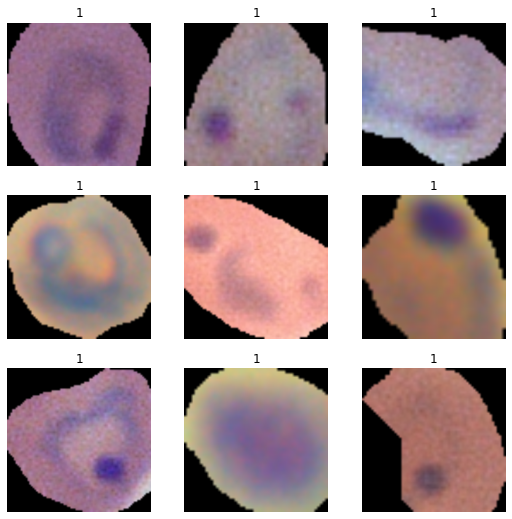

In [145]:
dls_test.show_batch()

In [157]:
crops = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0, seed=42),
   item_tfms=RandomResizedCrop(224, min_scale=1),
   batch_tfms=None)

In [158]:
path = r"C:\Users\AChub_Lab\Desktop\my_project\Falciparum-20210224T184021Z-001\Falciparum\crops"
dls_test = crops.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [160]:
dls_test.vocab = [0, 1, 3, 2]

In [164]:
dls_test.valid = dls_test.train

In [168]:
learn.validate(dl=dls_test.valid)

(#2) [10.665726661682129,0.995312511920929]

In [18]:
learn.export("test.pkl")

In [178]:
import cv2
from PIL import Image as PImage

In [181]:
path = r"C:\Users\AChub_Lab\Desktop\my_project\Falciparum-20210224T184021Z-001\Falciparum\crops\R\1305121398-0001-R_S_2.png"

frame = cv2.imread(path)
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
pil_im = PImage.fromarray(frame) 
x = vision.pil2tensor(pil_im ,np.float32)

img_scaled = cv2.resize(x, (224, 224), interpolation = cv2.INTER_AREA)
learn.predict(Image(img_scaled))

AttributeError: module 'fastai.vision' has no attribute 'pil2tensor'

In [190]:
def cv2_RGB_to_fai_img(self,img: np.ndarray) -> vision.Image:
   #expects RGB cv2 array
   return vision.Image(torch.tensor(np.ascontiguousarray(img).transpose(2,0,1)).float()/255)
#load image
pil_img = PImage.open(path)
rgb_img = np.array(pil_img.convert('RGB'))

#load model and predict
#learn = load_learner()
prediction = learn.predict(cv2_RGB_to_fai_img(rgb_img))

AttributeError: module 'fastai.vision' has no attribute 'Image'